Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [X] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [219]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [220]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [221]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [222]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [223]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [224]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [227]:
df= df.drop(columns=['Mass (g)','Density (g/mL)','Queso'])

# Train, Validate, Test Split



In [228]:
# Convert to Datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Split Data By Year
train = df[df['Date'].dt.year < 2017]
val = df[df['Date'].dt.year == 2017]
test = df[df['Date'].dt.year > 2017]

train.shape, val.shape, test.shape

((298, 56), (85, 56), (38, 56))

# Majority Classifier

In [229]:
print('Predicting False for every observation would result in 59% overall correct predictions')
train['Great'].value_counts(normalize=True)


Predicting False for every observation would result in 59% overall correct predictions


False    0.590604
True     0.409396
Name: Great, dtype: float64

# Logistic Regression

In [308]:
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [231]:
target = 'Great'
features = train.columns.drop([target,'Date'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_true = test[target]

In [232]:
# Instantiate Encoder

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [233]:
# Instantiate Imputer

imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)



In [234]:
# Instantiate Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [339]:
scores = []
feats = []
for k in range(1,120):
    selector = SelectKBest(k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_val_selected = selector.transform(X_val_scaled)
    
  
    model = LogisticRegression()
    model.fit(X_train_selected,y_train)
    y_pred = model.predict(X_val_selected)  
    s = accuracy_score(y_val,y_pred)
    feat = k
    scores.append(s)
    feats.append(feat) 
   
# Dataframe of lists
lowest_error = pd.DataFrame(scores,feats,columns=['score'])['score'].reset_index().nsmallest(1,columns=['score'])
lowest_error = lowest_error.reset_index(drop=True)
feat_nums = lowest_error.iloc[0,0]


selector = SelectKBest(k=feat_nums)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Fit Model
model = LogisticRegression()
model.fit(X_train_selected,y_train)

# Validation
y_pred = model.predict(X_val_selected)
score =  accuracy_score(y_val,y_pred)
print(f'A Basic Logistic Regression Model results in accuracy of {score} when validating')

#Final Prediction
y_pred = model.predict(X_test_selected)
score = accuracy_score(y_true,y_pred)
print(f'A Basic Logistic Regression Model results in accuracy of {score} in testing')
print(f'These Models consist of {feat_nums} features')


colnames = X_train_encoded.columns
selected_mask = selector.get_support()
col_sel = colnames[selected_mask]
col_unsel = colnames[~selected_mask]

feats = col_sel.to_list()
coef = model.coef_[0]

coefs = pd.DataFrame(coef,feats,columns=['coefs'])
coefs = coefs.reset_index()
coefs.columns = ['Feature','Coefficients']
coefs = coefs.sort_values(by='Coefficients',ascending=False)
coefs = coefs.reset_index()
plots1 = coefs.iloc[0:10,1]
plots2 = coefs.iloc[0:10,2]

plots3 = coefs.iloc[-10:-1,1]
plots4 = coefs.iloc[-10:-1,2]

A Basic Logistic Regression Model results in accuracy of 0.7411764705882353 when validating
A Basic Logistic Regression Model results in accuracy of 0.7894736842105263 in testing
These Models consist of 72 features


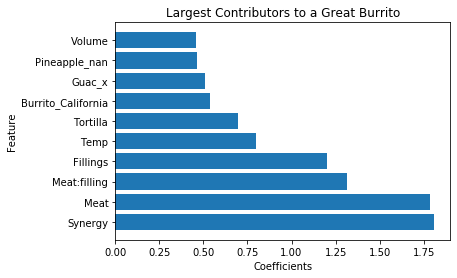

In [343]:
plt.barh(plots1,plots2)
plt.title('Largest Contributors to a Great Burrito')
plt.xlabel('Coefficients')
plt.ylabel('Feature')
plt.show()

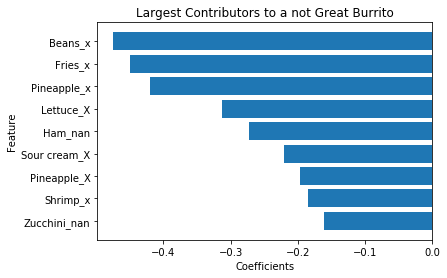

In [344]:
plt.barh(plots3,plots4)
plt.title('Largest Contributors to a not Great Burrito')
plt.xlabel('Coefficients')
plt.ylabel('Feature')
plt.show()